# 时间序列谱密度和均值估计
实验目的：联系并掌握均值估计的渐进效果
实验内容：对数据画出谱密度图，均值估计的相合性和渐进正态性

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

![](./img/2_1.png)

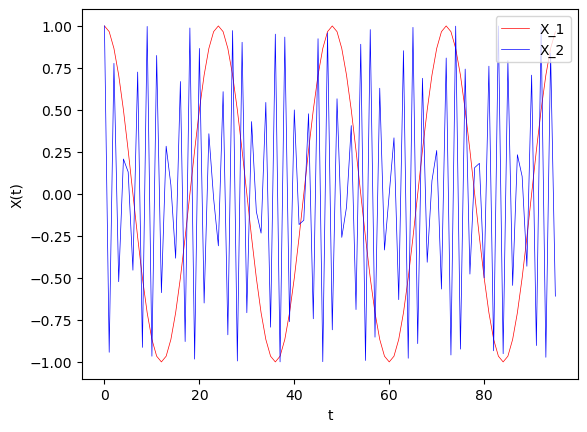

In [2]:
def X_1(t):
    return np.cos(2*np.pi*t*4/96)
def X_2(t):
    return np.cos(2*np.pi*t*(14/96+0.3))
interval=1
plt.plot(np.arange(0,96,interval),X_1(np.arange(0,96,interval)),label='X_1',color='red',linestyle='-',linewidth=0.5)
plt.plot(np.arange(0,96,interval),X_2(np.arange(0,96,interval)),label='X_2',color='blue',linestyle='-',linewidth=0.5)
plt.legend(loc='upper right')
plt.xlabel('t')
plt.ylabel('X(t)')
#图片大小
plt.rcParams['figure.figsize'] = (10.0, 4.0)
plt.show()

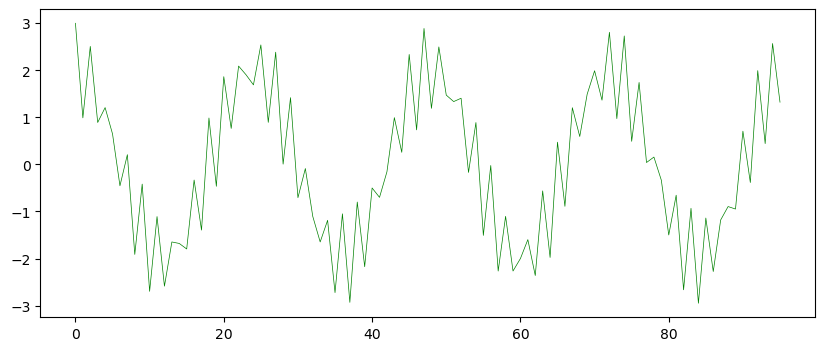

In [3]:
def Y(t):
    return 2*X_1(t)+X_2(t)
plt.plot(np.arange(0,96,interval),Y(np.arange(0,96,interval)),label='Y',color='green',linestyle='-',linewidth=0.5)
plt.show()

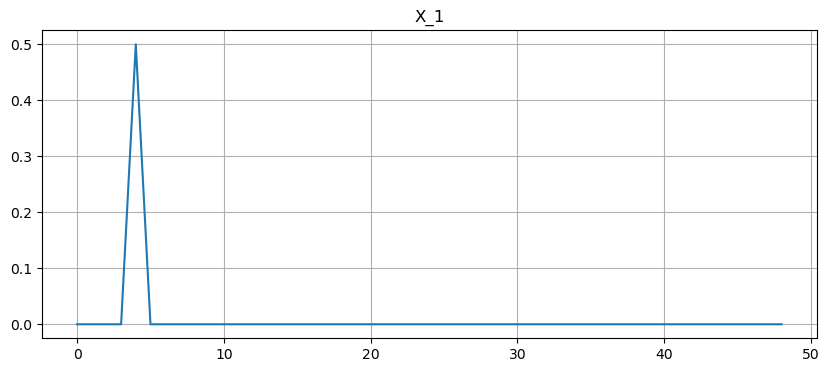

In [4]:
#X_1，X_2,Y的谱密度图
from scipy import signal
f, Pxx_den= signal.periodogram(X_1(np.arange(0,96)), 96)
#plt.vlines(f, 0, Pxx_den, colors='black', lw=2)  # 使用垂直线绘制周期图谱
#plt.plot(f, Pxx_den, 'r.')
plt.plot(f, Pxx_den)
plt.title('X_1')
plt.grid()
plt.show()

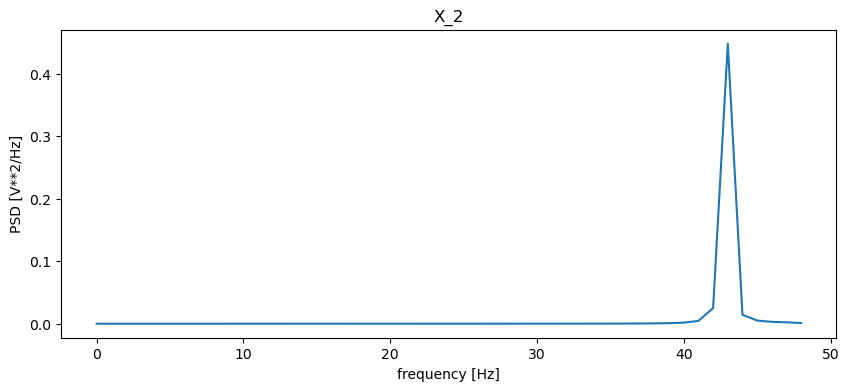

In [5]:
f, Pxx_den = signal.periodogram(X_2(np.arange(0,96,interval)), 96)
plt.plot(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('X_2')
plt.show()

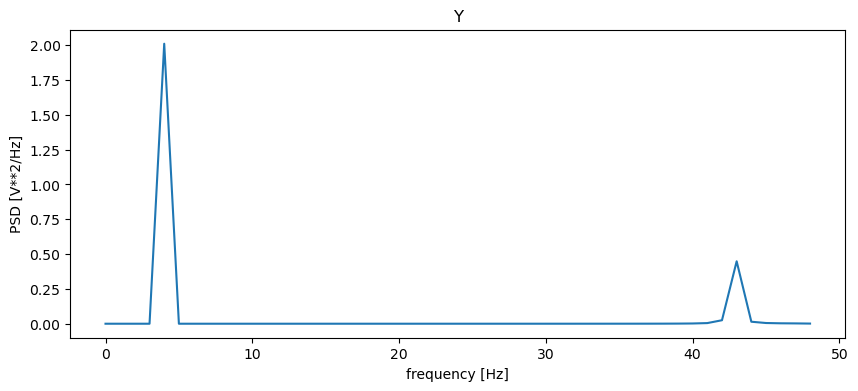

In [6]:
f, Pxx_den = signal.periodogram(Y(np.arange(0,96,interval)), 96)
plt.plot(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Y')
plt.show()

![](./img/2_2.png)

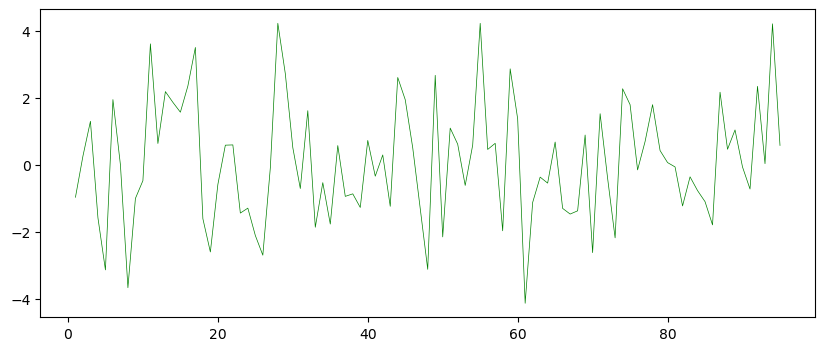

In [7]:
interval=1
t=np.arange(1,96,interval)
w=2*np.pi*t

def generate():#A_1,A_2,B_1,B_2为相互独立的正态分布
    A_1=np.random.randn()
    A_2=np.random.randn()
    B_1=np.random.randn()
    B_2=np.random.randn()
    A_2=A_2*np.sqrt(2)
    B_2=B_2*np.sqrt(2)
    return A_1,A_2,B_1,B_2

def Y(t):
    rand_normal=np.random.randn(len(t))
    Ans=np.zeros(len(t))
    
    for i in range(len(t)):
        A_1,A_2,B_1,B_2=generate()
        Ans[i]=A_1*np.cos(w[i]/96)+A_2*np.sin(w[i]/96)+B_1*np.cos(2*w[i]/96)+B_2*np.sin(2*w[i]/96)+rand_normal[i]
    return Ans
Y=Y(t)
plt.plot(t,Y,label='Y',color='green',linestyle='-',linewidth=0.5)
plt.show()

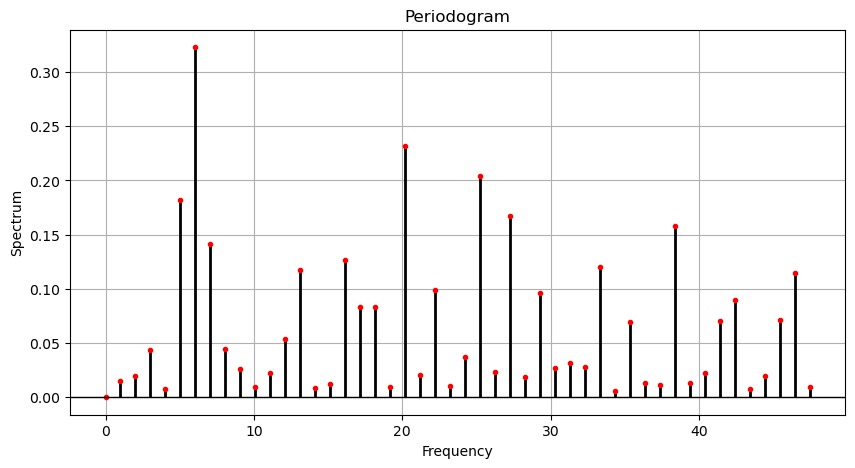

两个峰尖频率为[ 6.06315789 20.21052632]


In [8]:
frequencies, psd = signal.periodogram(Y, 96)
# 绘制周期图谱，每个频率成分都是一个垂直线
plt.figure(figsize=(10, 5))
plt.vlines(frequencies, 0, psd, colors='black', lw=2)  # 使用垂直线绘制周期图谱
plt.plot(frequencies, psd, 'r.')  # 红点标记每个频率点
plt.xlabel('Frequency')
plt.ylabel('Spectrum')
plt.title('Periodogram')
plt.grid(True)

# 添加水平基线 y=0
plt.axhline(y=0, color='k', lw=1)  # 使用黑色线绘制 y=0 基线

plt.show()
#取出图中最高的两个点
df=pd.DataFrame([frequencies,psd]).T
print(f'两个峰尖频率为{df.nlargest(n=2,columns=1).iloc[:,0].values}')

![](./img/2_3.png)

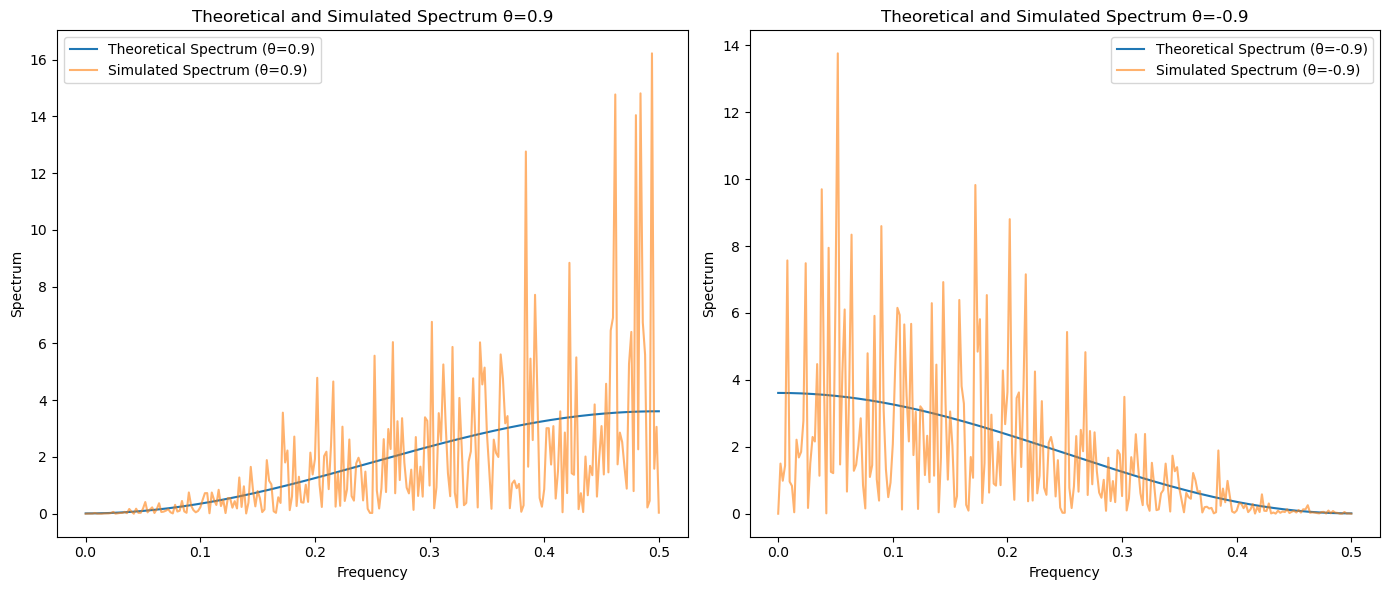

In [9]:
from statsmodels.tsa.arima_process import arma_generate_sample,ArmaProcess
from scipy.signal import periodogram
import matplotlib.pyplot as plt
import numpy as np
# 首先重新定义我们的时间序列生成函数，因为之前的环境已重置
def generate_ma_series(theta, size=500):
    """生成MA(1)时间序列"""
    np.random.seed(1)  # 设置随机种子以确保结果的可复现性
    ma_coefs = np.array([1, -theta])  # MA模型的参数,注意这里是-theta
    ar_coefs = np.array([1])  # AR模型的参数，# 没有AR部分，所以只有[1]
    return arma_generate_sample(ar=ar_coefs, ma=ma_coefs, nsample=size,scale=0.7)
    #scale是标准差，ar是AR模型的参数，ma是MA模型的参数，nsample是生成的样本数
# 生成两个MA(1)时间序列
y1 = generate_ma_series(theta=0.9)
y2 = generate_ma_series(theta=-0.9)

# 计算模拟序列的谱密度
f1, Pxx_den1 = periodogram(y1,scaling='density')
f2, Pxx_den2 = periodogram(y2,scaling='density')

# 定义理论谱密度计算函数
def theoretical_spectrum(theta, f):
    """计算理论谱密度"""
    return (1 + theta**2 - 2*theta*np.cos(2*np.pi*f))
    #return (1-theta*np.exp(-0.j*2*np.pi*f))**2

# 计算理论谱密度
frequencies = np.linspace(0, 0.5, len(f1))  # 生成频率数组
theor_spectrum1 = theoretical_spectrum(0.9, frequencies)
theor_spectrum2 = theoretical_spectrum(-0.9, frequencies)

# 绘制模拟序列与理论谱密度的比较图
plt.figure(figsize=(14, 6))
# 对于 theta=0.9
plt.subplot(1, 2, 1)
plt.plot(frequencies, theor_spectrum1, label='Theoretical Spectrum (θ=0.9)')
plt.plot(f1, Pxx_den1, label='Simulated Spectrum (θ=0.9)', alpha=0.6)#alpha是透明度
plt.title('Theoretical and Simulated Spectrum θ=0.9')
plt.xlabel('Frequency')
plt.ylabel('Spectrum')
plt.legend()


# 对于 theta=-0.9
plt.subplot(1, 2, 2)
plt.plot(frequencies, theor_spectrum2, label='Theoretical Spectrum (θ=-0.9)')
plt.plot(f2, Pxx_den2, label='Simulated Spectrum (θ=-0.9)', alpha=0.6)
plt.title('Theoretical and Simulated Spectrum θ=-0.9')
plt.xlabel('Frequency')
plt.ylabel('Spectrum')
plt.legend()

plt.tight_layout()#自动调整子图参数，使之填充整个图像区域
plt.show()

![](./img/2_4.png)

In [10]:
N=[10,20,40,100,400,600,1000]
theta=2.34
rho=1/4
sigma = 1  # εt的标准差

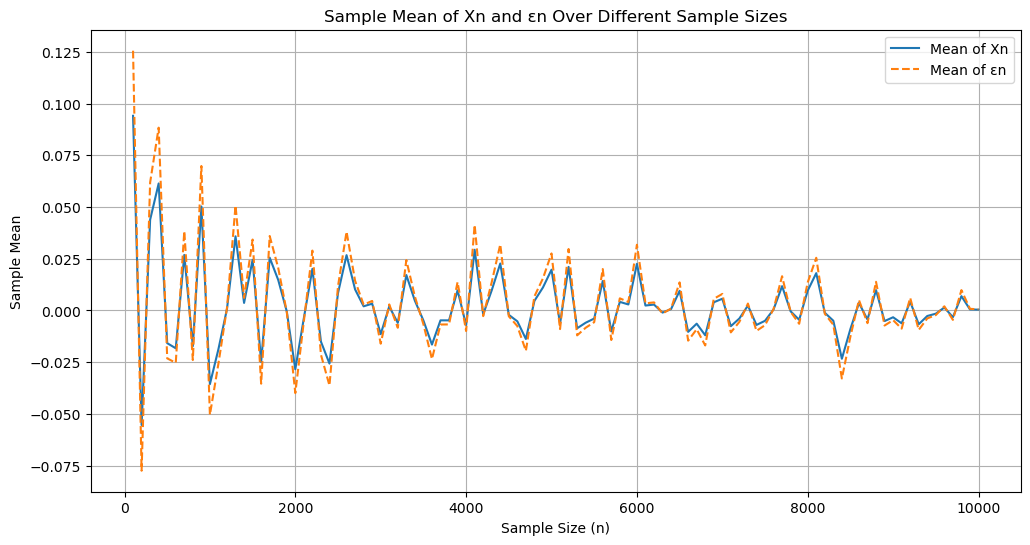

In [11]:
# 模拟时间序列函数
def simulate_time_series(n, rho, theta, sigma):
    #n是样本量，rho是AR(2)的参数，theta是AR(2)的参数，sigma是白噪声的标准差
    """模拟AR(2)时间序列"""
    # 初始化时间序列数组
    X = np.zeros(n)
    # 生成白噪声
    epsilon = sigma * np.random.randn(n)#randn函数返回一个或一组样本，具有标准正态分布。
    
    # 由于Xt依赖于前两项，我们需要初始化X1和X2
    X[0] = epsilon[0]
    X[1] = 2 * rho * np.cos(theta) * X[0] - rho**2 * X[0] + epsilon[1]#递推
    
    # 生成时间序列数据
    for t in range(2, n):
        X[t] = 2 * rho * np.cos(theta) * X[t-1] - rho**2 * X[t-2] + epsilon[t]
    
    return X, epsilon#返回AR(2)的时间序列和白噪声

# 样本量列表
sample_sizes = np.arange(100, 10001, 100)

# 初始化样本均值列表
mean_Xn = []
mean_epsn = []

# 对不同的样本量计算样本均值
for n in sample_sizes:
    X, epsilon = simulate_time_series(n, rho, theta, sigma)#X是AR(2)的时间序列，epsilon是白噪声
    mean_Xn.append(np.mean(X))
    mean_epsn.append(np.mean(epsilon))

# 绘制曲线图
plt.figure(figsize=(12, 6))
plt.plot(sample_sizes, mean_Xn, label='Mean of Xn')
plt.plot(sample_sizes, mean_epsn, label='Mean of εn', linestyle='--')
plt.xlabel('Sample Size (n)')
plt.ylabel('Sample Mean')
plt.title('Sample Mean of Xn and εn Over Different Sample Sizes')
plt.legend()
plt.grid(True)
plt.show()

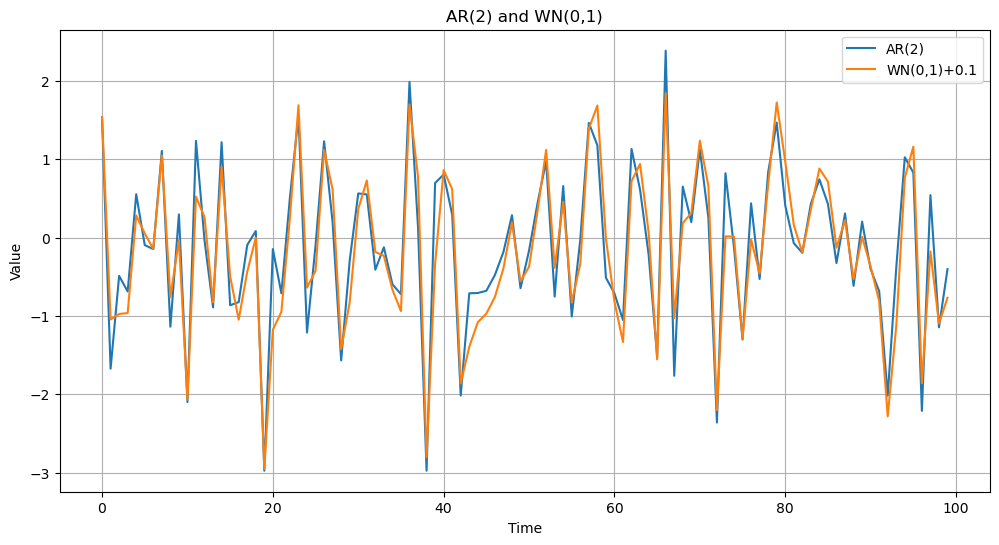

In [12]:
#绘制AR(2)和 WN(0,1)的时序图
X, epsilon = simulate_time_series(100, rho, theta, sigma)
plt.figure(figsize=(12, 6))
plt.plot(X, label='AR(2)')
plt.plot(epsilon, label='WN(0,1)+0.1')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('AR(2) and WN(0,1)')
plt.legend()
plt.grid(True)
plt.show()